In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline


In [2]:
#Acquiring the dataset from CSV file
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#Dropping last three columns, (since the dataset has the last three columns filled with nan values)
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

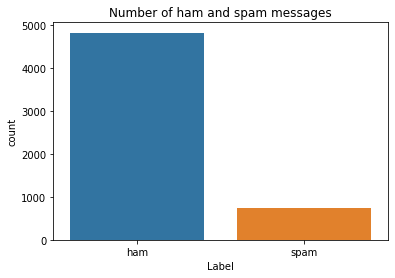

In [4]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [5]:
labels = df.v1.to_numpy()
ham = sum(labels=="ham")
print("Ham: " +  str(ham)+ " Spam: " + str(5572-ham))

Ham: 4825 Spam: 747


In [6]:
X = df.v2
Y = df.v1
#Encoding labels
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
#Splitting the dataset into train and test set (85%-15%)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
#Plotting histogram with spam and ham phrases on the train set
print("Xtrain shape == ", X_train.shape)
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
seq = tok.fit_on_texts(X_train)
#below function turn words in text to sequence numbers 
sequences = tok.texts_to_sequences(X_train)
print("sequences",sequences)
print("Length of sequence == ",len(sequences))


Xtrain shape ==  (4736,)
sequences [[85, 76, 16, 98], [86, 2, 49, 3, 381, 51, 692], [87, 76, 16, 3, 46, 34, 598], [22], [211, 6, 93, 30, 9, 382, 38, 734, 128, 409, 25, 7, 38, 734, 212, 693, 93, 136, 7, 735, 14, 38, 93, 92], [115, 39, 57, 42, 41, 104, 104], [104, 26, 6, 68, 2, 573, 10, 32, 98, 323, 159, 29, 16, 6, 162, 284], [34, 29, 80, 96, 16], [33, 1, 912, 1, 68, 6, 2, 17, 48, 11], [129, 40, 69, 3, 663, 33, 27, 58, 181, 40, 69, 141, 3, 4, 976, 2, 295, 17, 4, 496, 66], [548, 218, 22, 16, 633, 427, 49, 109, 195, 913, 2, 338, 195, 2, 83, 444, 16, 481, 195], [267, 324, 35, 114, 48, 116, 54, 46, 238, 203], [185, 66, 1, 263, 2, 239, 162, 42, 41, 23, 64], [634], [87, 48, 5, 288, 635], [977, 114, 112, 16, 182], [694, 271, 105], [67, 5, 15, 6, 44, 31, 914], [1, 151, 97, 847, 32, 53, 5, 330], [16, 12, 64, 109, 249, 636, 16, 49, 4, 339, 848, 978, 156, 37, 979, 978], [1, 17, 229], [369, 22, 117, 130, 33, 117, 47, 245, 915, 9], [24, 1, 549, 57, 55, 43], [182, 16, 49, 331, 13, 43, 272, 25, 410, 15

In [7]:
#This function transforms a list of num_samples sequences (lists of integers) into a 2D
#Numpy array of shape (num_samples, num_timesteps). num_timesteps
#is either the maxlen argument if provided, or the length of the longest sequence otherwise
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
print("shape of sequence matrix == ",sequences_matrix.shape)


shape of sequence matrix ==  (4736, 150)


In [8]:
#defining the Recurrent Neural Network model
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model


model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [9]:
#Training
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

#Preparation of a sequence with the test set and test evaluation
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
test_pred = model.predict(test_sequences_matrix)
test_pred = np.round(test_pred,0)
print("predicted spam as 1, ham as 0",test_pred)

Epoch 1/10
30/30 [==============================] - 3s 111ms/step - loss: 0.3325 - accuracy: 0.8683 - val_loss: 0.1421 - val_accuracy: 0.9662

In [11]:
train_acc = history.history['accuracy'][-1]

In [10]:
#Computing accuracy
accr = model.evaluate(test_sequences_matrix,Y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

27/27 [==============================] - 0s 17ms/step - loss: 0.0456 - accuracy: 0.9868
Test set
  Loss: 0.046
  Accuracy: 0.987


In [46]:
#Making our test
test = pd.Series(["Dear Dr. A. Sebastian Podda, Thank you for uploading your university paper to PerAwareCity 2021", "You won 1000 dollars! Click below to check your bank account"])

pre = tok.texts_to_sequences(test)
pre = sequence.pad_sequences(pre, maxlen=max_len)

y = np.round(model.predict(pre),0)

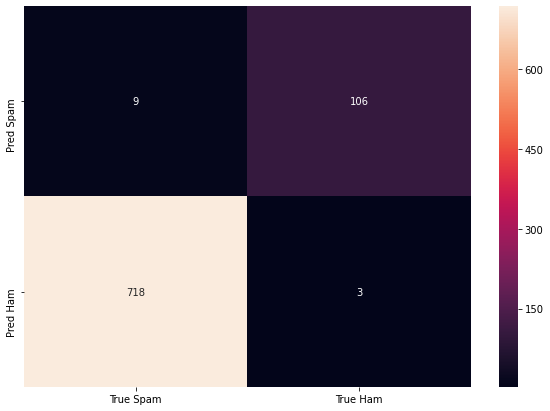

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
def confusion_matrices(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred,labels=[0, 1]).ravel()
    array = [[tp, fp], [fn, tn]]
    df_cm = pd.DataFrame(array, index = ["Pred Spam", "Pred Ham"],
                      columns = ["True Spam", "True Ham"])
    plt.figure(figsize = (10,7))
    fig = sn.heatmap(df_cm, annot=True, fmt="d")
    fig.get_figure().savefig('/home/andrea/Scrivania/confMat.png', dpi=400)

confusion_matrices(np.round(model.predict(test_sequences_matrix),0), Y_test)

In [18]:
np.round(model.predict(test_sequences_matrix),0)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],